In [1]:
from typing import Any
import numpy as np
import pandas as pd
from lisatools.diagnostic import snr as snr_func
from lisatools.diagnostic import plot_covariance_contour, plot_covariance_corner
from lisatools.sensitivity import get_sensitivity, A1TDISens
from lisatools.detector import scirdv1, Orbits, DefaultOrbits, LISAModel
from lisatools.utils.constants import *
from lisatools.sources import BBHCalculationController, GBCalculationController, EMRICalculationController
from lisatools.sources.emri import EMRITDIWaveform
from lisatools.sources.bbh import BBHSNRWaveform
from lisatools.sources.gb import GBAETWaveform

from gwspaceperf import Mission
from gwspaceperf.performance import sensitivity, noise_psd

from abc import ABC
from typing import Union, Tuple
import matplotlib.pyplot as plt
from scipy import interpolate

%matplotlib inline

/var/folders/j0/bh276m5s531565_7zdy_t5m40000gp/T/ipykernel_88951/292967234.py:3: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


No CuPy
No CuPy or GPU PhenomHM module.
No CuPy or GPU response available.
No CuPy or GPU interpolation available.


Define model class based on `lisatools.detector.LISAModel`. This interacts with the sensitivity curve generator inside `lisatools` to properly include model information.

In [2]:
class Space2050Model:
    """Model for future space-based GW missions.

    Args:
        mission: ``gwspaceperf.Mission``.
        orbits: ``lisatools.detector.Orbits``.
        name: Name for model instance.

    """

    def __init__(self, mission: Mission, orbits: Orbits, name: str):
        # store spline
        self.orbits = orbits
        self.name = name
        self._setup_splines(mission)

    @property
    def Sn_spl(self) -> interpolate.CubicSpline | None:
        """PSD spline dictionary."""
        if not hasattr(self, "_Sn_spl"):
            return None

        return self._Sn_spl

    @property
    def fn(self) -> np.ndarray:
        """Frequency array for splines."""
        return self._fn

    def _setup_splines(self, mission: Mission) -> None:
        """Prepare the splines accordingly"""
        Sn = noise_psd(mission, "AET")
        self._fn = mission.f
        self._Sn_spl = {
            key: interpolate.CubicSpline(self._fn, Sn[:, i])
            for i, key in enumerate(["A", "E", "T"])
        }

## Define mission characteristics

In [3]:
# Define a frequency axis
f_mu = np.logspace(-7, 0, 1000)
f_m = np.logspace(-4, 0, 1000)
f_d = np.logspace(-3, 1, 1000)

# Define the LISA-like mission
lisa_mission = Mission.LISA(f_m)
lisamax_mission = Mission.LISAmax(f_mu)
do_con_mission = Mission.DO_conservative(f_d)
do_opt_mission = Mission.DO_optimal(f_d)
# amigo = Mission.AMIGO(f_m)
muares_mission = Mission.muAres(f_mu)

In [4]:
missions = {}

def get_df(Tobs: float, dt: float) -> float:
    Nobs = int(Tobs / dt)
    Tobs = Nobs * dt
    df = 1 / Tobs
    return df


In [5]:
lisa_orbits = Orbits("../space_2050_models/lisa_orbits.h5", armlength=2.5e9)

lisa = Space2050Model(
    lisa_mission, lisa_orbits, "lisa"
)

psd_kwargs = dict(
    # stochastic_params=(10.0 * YRSID_SI,),
)

missions["lisa"] = dict(
    model=lisa,
    psd_kwargs=psd_kwargs,
    Tobs=YRSID_SI, 
    dt=10.0
)

In [6]:

lisamax_orbits = Orbits("../space_2050_models/lisamax_orbits.h5", armlength=2.59e+11)
lisa_max = Space2050Model(
    lisamax_mission, lisamax_orbits, "lisa_max"
)
psd_kwargs = dict(
    # stochastic_params=(10.0 * YRSID_SI,),
)
missions["lisamax"] = dict(
    model=lisa_max,
    psd_kwargs=psd_kwargs,
    Tobs=YRSID_SI, 
    dt=20.0
)

muares = Space2050Model(
    muares_mission, lisamax_orbits, "muares"
)
psd_kwargs = dict(
    # stochastic_params=(10.0 * YRSID_SI,),
)
missions["muares"] = dict(
    model=muares,
    psd_kwargs=psd_kwargs,
    Tobs=YRSID_SI, 
    dt=20.0
)

In [7]:
do_orbits = Orbits("../space_2050_models/deci_orbits.h5", armlength=1e8)

do_con = Space2050Model(
    do_con_mission, do_orbits, "do_con"
)

psd_kwargs = dict(
    # stochastic_params=(10.0 * YRSID_SI,),
)

missions["do_con"] = dict(
    model=do_con,
    psd_kwargs=psd_kwargs,
    Tobs=YRSID_SI / 2.0, 
    dt=0.5
)

do_opt = Space2050Model(
    do_opt_mission, do_orbits, "do_opt"
)

psd_kwargs = dict(
    # stochastic_params=(10.0 * YRSID_SI,),
)

missions["do_opt"] = dict(
    model=do_opt,
    psd_kwargs=psd_kwargs,
    Tobs=YRSID_SI / 2.0, 
    dt=0.5
)

## Diagnostics

Setup all snr calculators

In [8]:
for mission in missions:
    print(mission)
    orbits_here = missions[mission]["model"].orbits
    # black hole generator
    bbh = BBHSNRWaveform(response_kwargs=dict(TDItag="AET", orbits=orbits_here, tdi2=True))

    missions[mission]["bbh"] = BBHCalculationController(
        bbh, 
        missions[mission]["model"],
        missions[mission]["psd_kwargs"], 
        missions[mission]["Tobs"] / YRSID_SI,
        missions[mission]["dt"],
        psd=A1TDISens
    )
    
    # gb generator
    gb = GBAETWaveform(orbits=orbits_here)

    missions[mission]["gb"] = GBCalculationController(
        gb, 
        missions[mission]["model"], 
        missions[mission]["psd_kwargs"], 
        missions[mission]["Tobs"] / YRSID_SI,
        missions[mission]["dt"],
        psd=A1TDISens
    )

    # emri generator
    emri = EMRITDIWaveform(
        T=missions[mission]["Tobs"] / YRSID_SI,  # in sec
        dt=missions[mission]["dt"], 
        response_kwargs=dict(tdi="2nd generation", orbits=orbits_here)
    )

    missions[mission]["emri"] = EMRICalculationController(
        emri, missions[mission]["model"], 
        missions[mission]["psd_kwargs"], 
        missions[mission]["Tobs"] / YRSID_SI,  # in sec
        missions[mission]["dt"],
        psd=A1TDISens
    )
    


lisa
lisamax
muares
do_con
do_opt


### MBHBs

lisa 1774.94610236217
lisamax 235877.55577486474
muares 7201144.783825578
do_con 78.8169300806267
do_opt 78.88191028341761


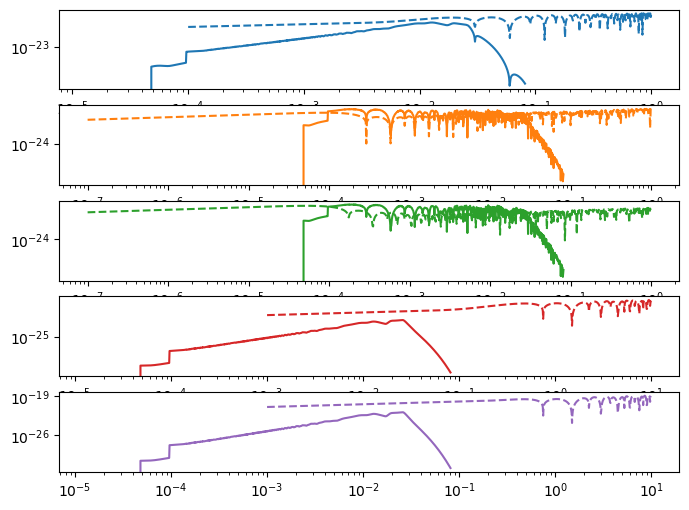

In [9]:
# in SSB

f_ref = 0.0  # let phenom codes set f_ref -> fmax = max(f^2A(f))
phi_ref = 0.5  # phase at f_ref
m1 = 1e6
m2 = 5e5
M = m1 + m2
q = m2 / m1  # m2 less than m1
a1 = 0.2
a2 = 0.4
dist = 10.0 * PC_SI * 1e9  # in m
inc = np.pi / 3.0
beta = np.pi / 4.0  # ecliptic latitude
lam = np.pi / 5.0  # ecliptic longitude
psi = np.pi / 6.0  # polarization angle

t_ref = YRSID_SI * 0.25  # (in the SSB reference frame)

mbh_injection_params = np.array(
    [m1, m2, a1, a2, dist, phi_ref, f_ref, inc, lam, beta, psi, t_ref]
)
fig, ax = plt.subplots(len(list(missions.keys())), 1, figsize=(8, 6))
for i, (name, mission) in enumerate(missions.items()):
    fn = mission["model"].fn
    print(name, mission["bbh"].get_snr(*mbh_injection_params))
    Sn = get_sensitivity(fn, model=mission["model"], sens_fn=A1TDISens, **mission["psd_kwargs"])
    ax[i].loglog(mission["bbh"].f_arr, mission["bbh"].f_arr * np.abs(mission["bbh"].last_output[0]), c=f"C{i}")
    df = get_df(mission["Tobs"], mission["dt"])
    ax[i].loglog(fn, np.sqrt(fn) * (Sn / (4 * df)) ** (1/2), c=f"C{i}", ls="--")


In [10]:
# example with last mission
scaled_inj_params, cov = mission["bbh"].get_cov(
    *mbh_injection_params,
    precision=True,
    more_accurate=False,
    eps=1e-9,
    deriv_inds=None,
)


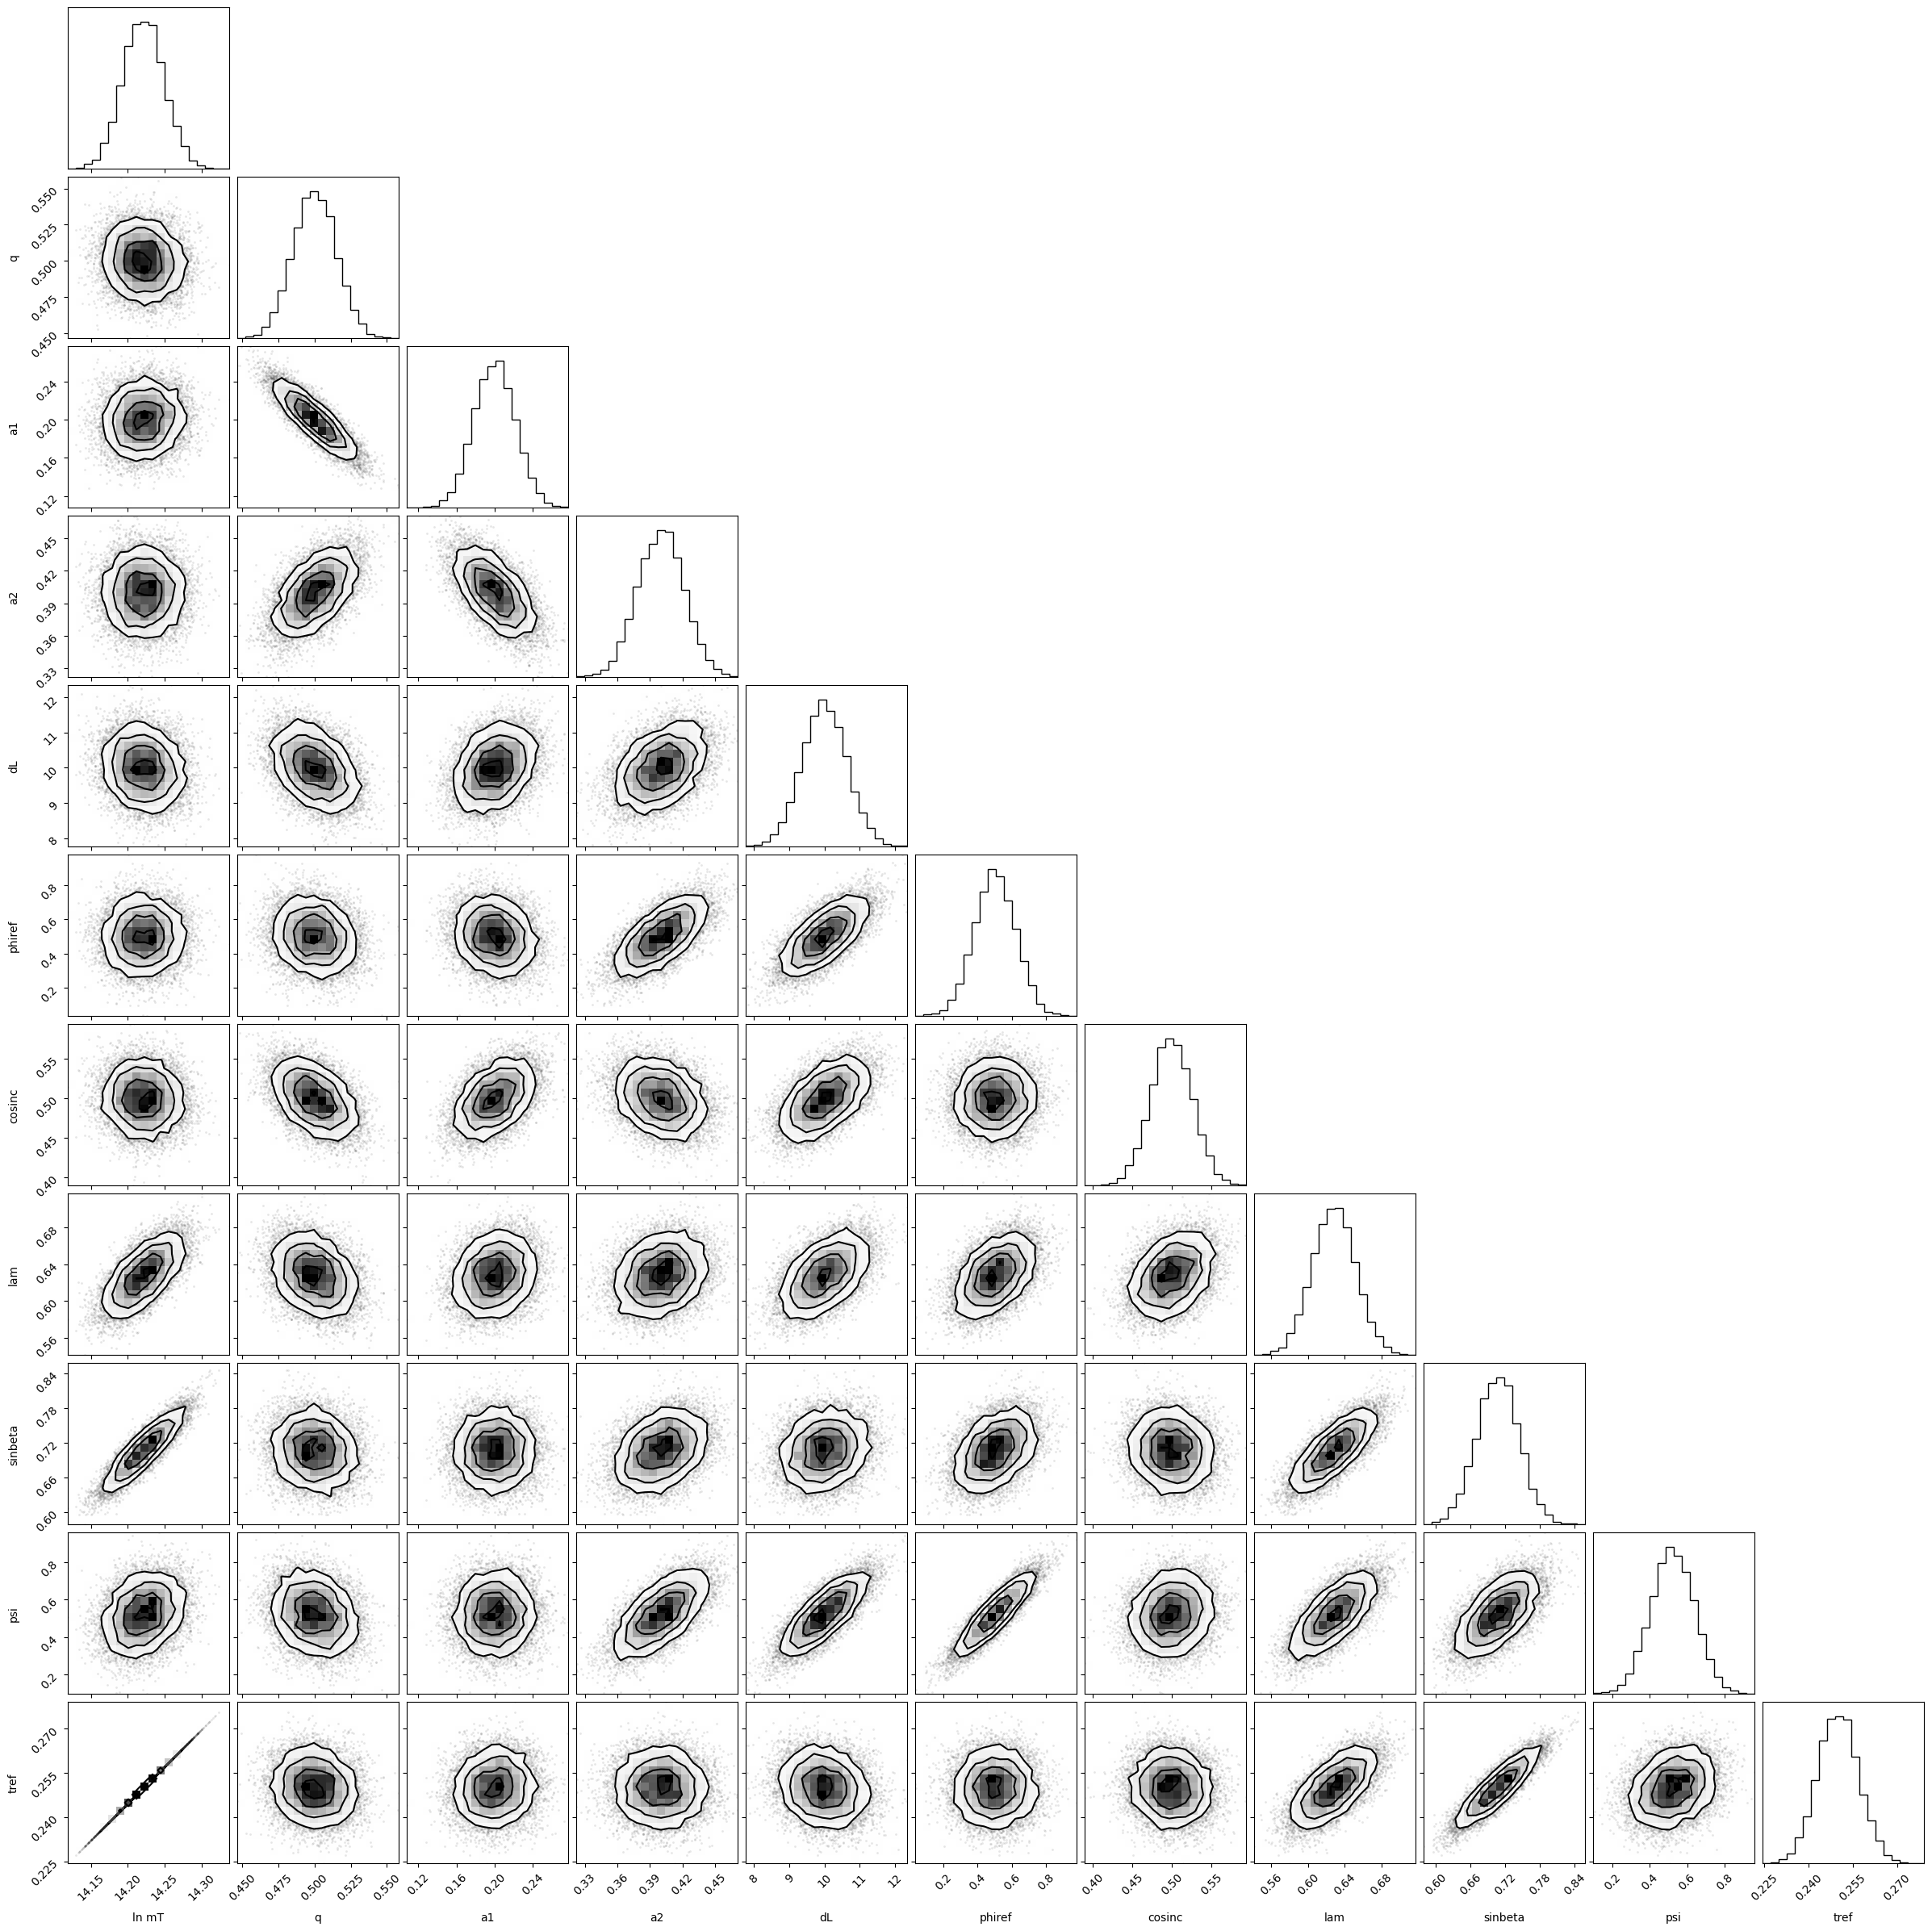

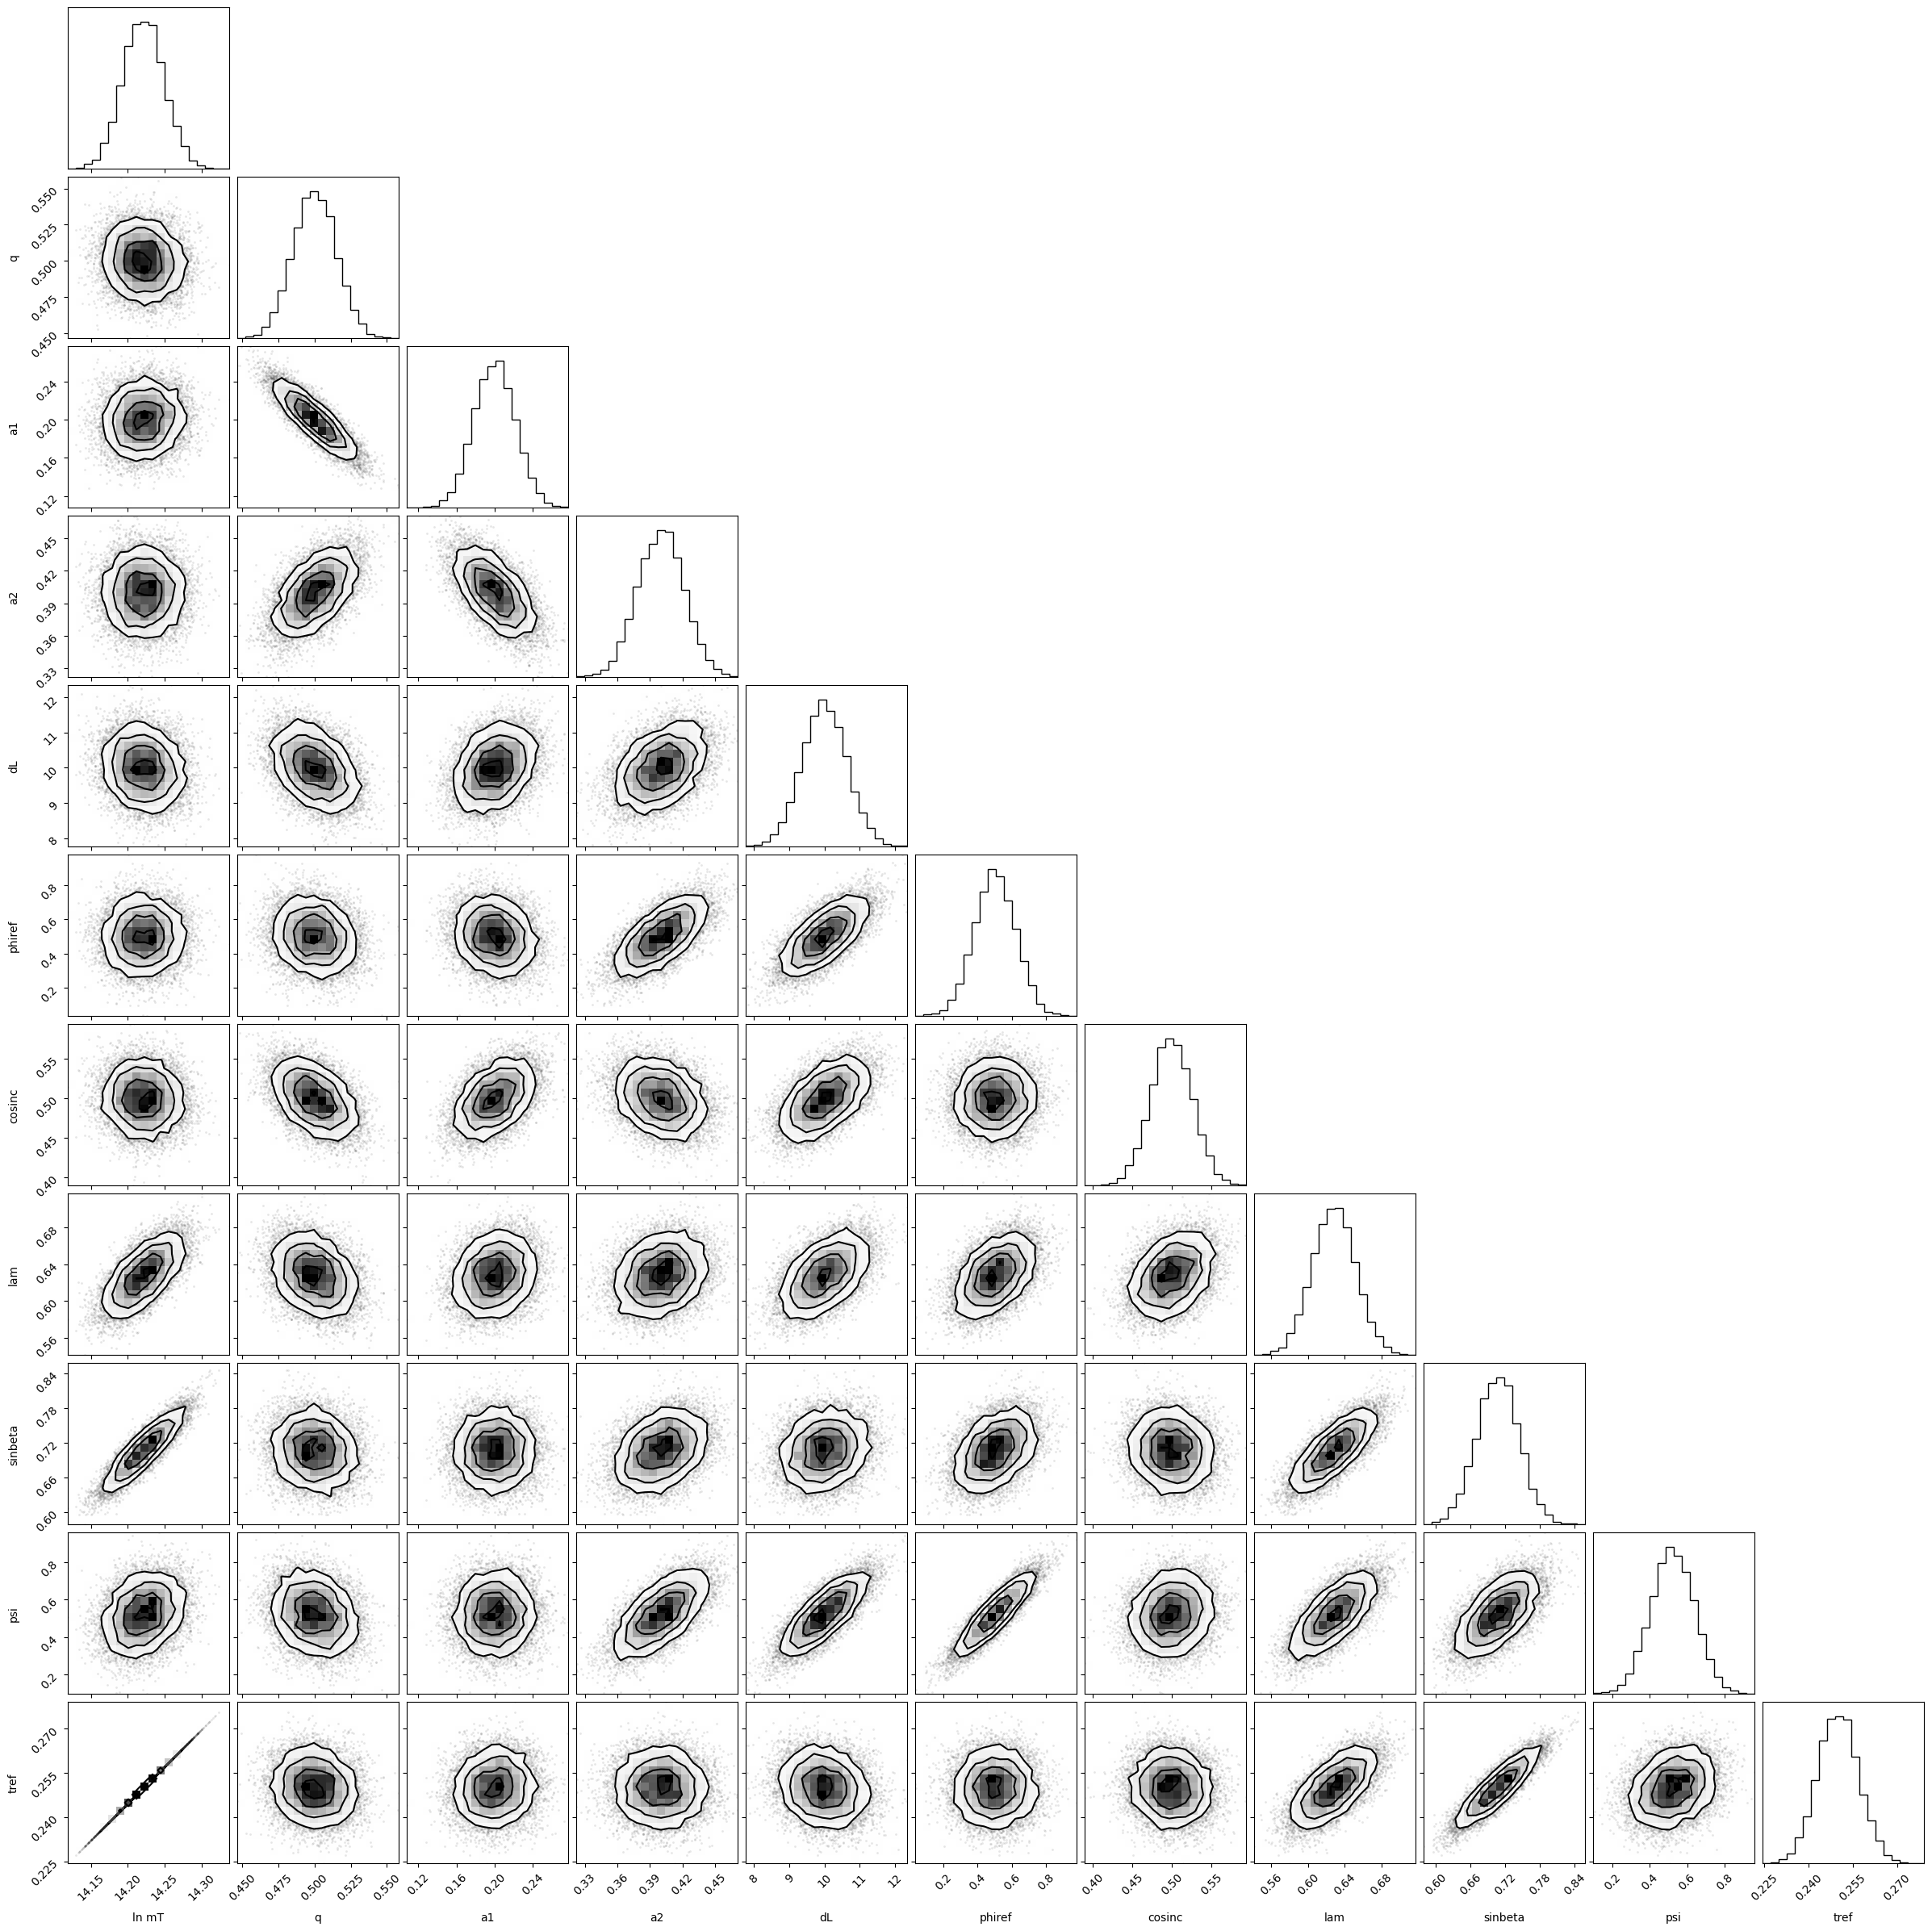

In [11]:
labels=["ln mT", "q", "a1", "a2", "dL", "phiref", "cosinc", "lam", "sinbeta", "psi", "tref"]
plot_covariance_corner(scaled_inj_params, cov, labels=labels, nsamp=10000)

### GBs

lisa 55.39699987183522
lisamax 2894.8960441386107
muares 12136.820893219368
do_con 0.3516139964951968
do_opt 0.35161439438906467


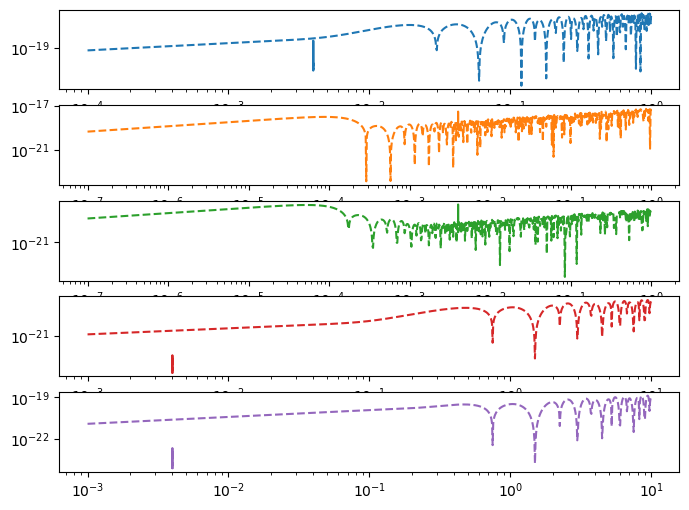

In [12]:
amp = 1e-22
f0 = 4e-3
fdot = 1e-18
fddot = 0.0
phi0 = 0.5
inc = 0.2
psi = 0.6
lam = 0.9
beta = -0.2
    
gb_injection_params = np.array([amp, f0, fdot, fddot, phi0, inc, psi, lam, beta])
fig, ax = plt.subplots(len(list(missions.keys())), 1, figsize=(8, 6))
for i, (name, mission) in enumerate(missions.items()):
    fn = mission["model"].fn
    print(name, mission["gb"].get_snr(*gb_injection_params))
    Sn = get_sensitivity(fn, model=mission["model"], sens_fn=A1TDISens, **mission["psd_kwargs"])
    ax[i].loglog(mission["gb"].f_arr, mission["gb"].f_arr * np.abs(mission["gb"].last_output[0]), c=f"C{i}")
    df = get_df(mission["Tobs"], mission["dt"])
    ax[i].loglog(fn, np.sqrt(fn) * (Sn / (4 * df)) ** (1/2), c=f"C{i}", ls="--")

In [13]:
scaled_inj_params, cov = mission["gb"].get_cov(
    *gb_injection_params,
    precision=True,
    more_accurate=False,
    eps=1e-11,
    deriv_inds=None,
)

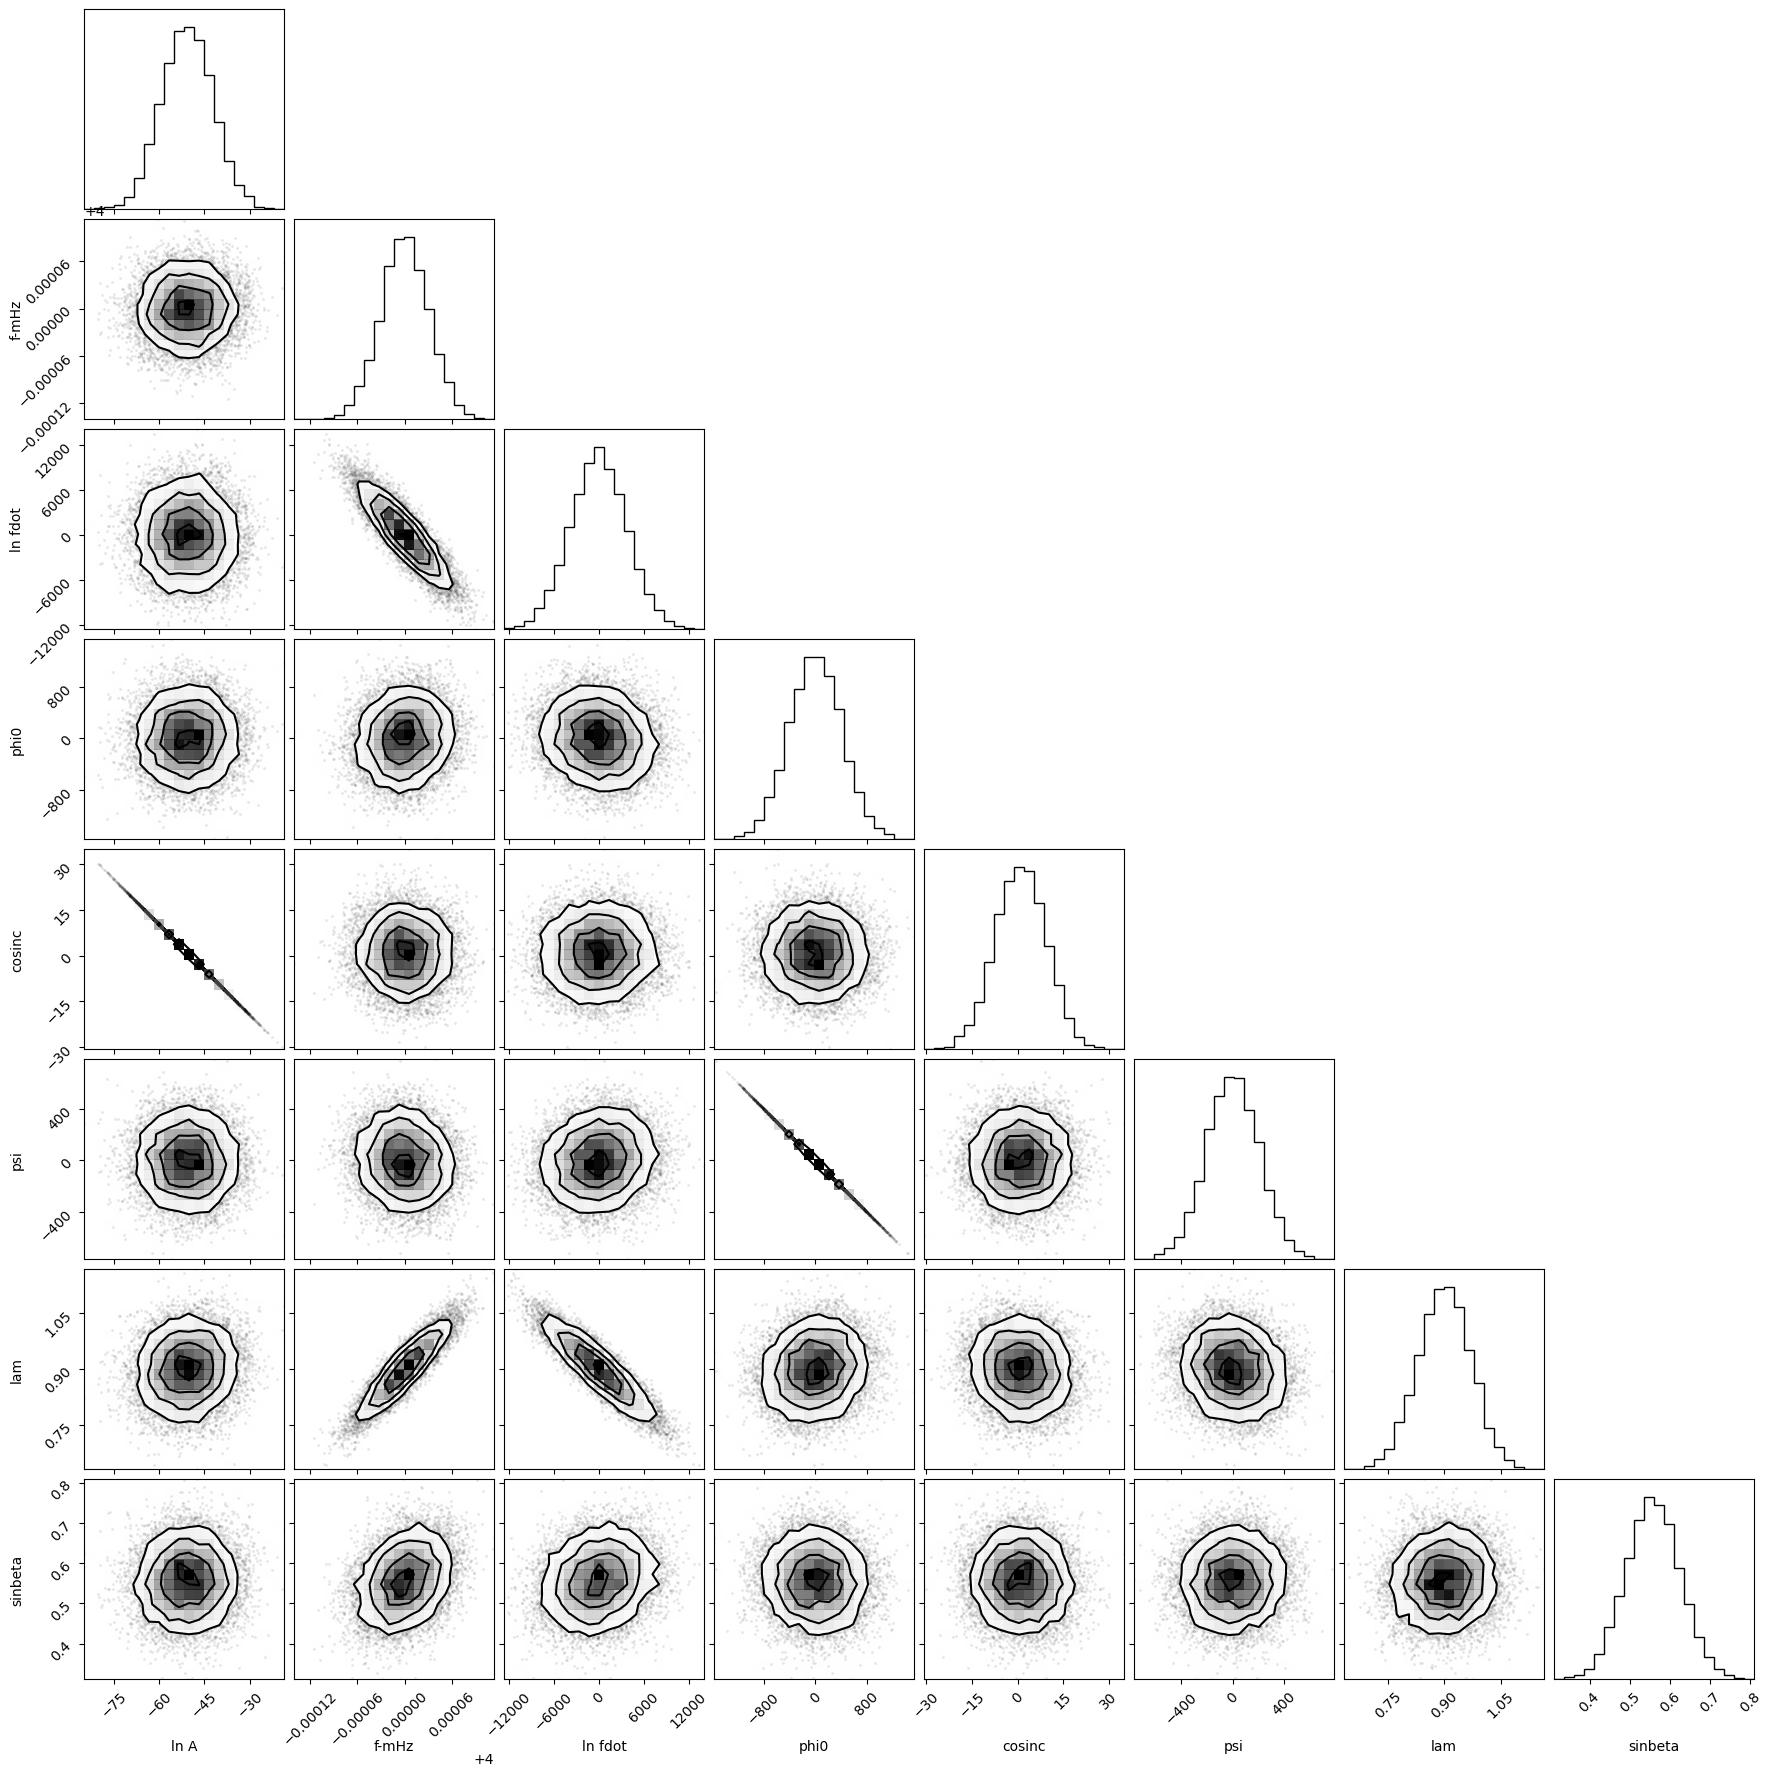

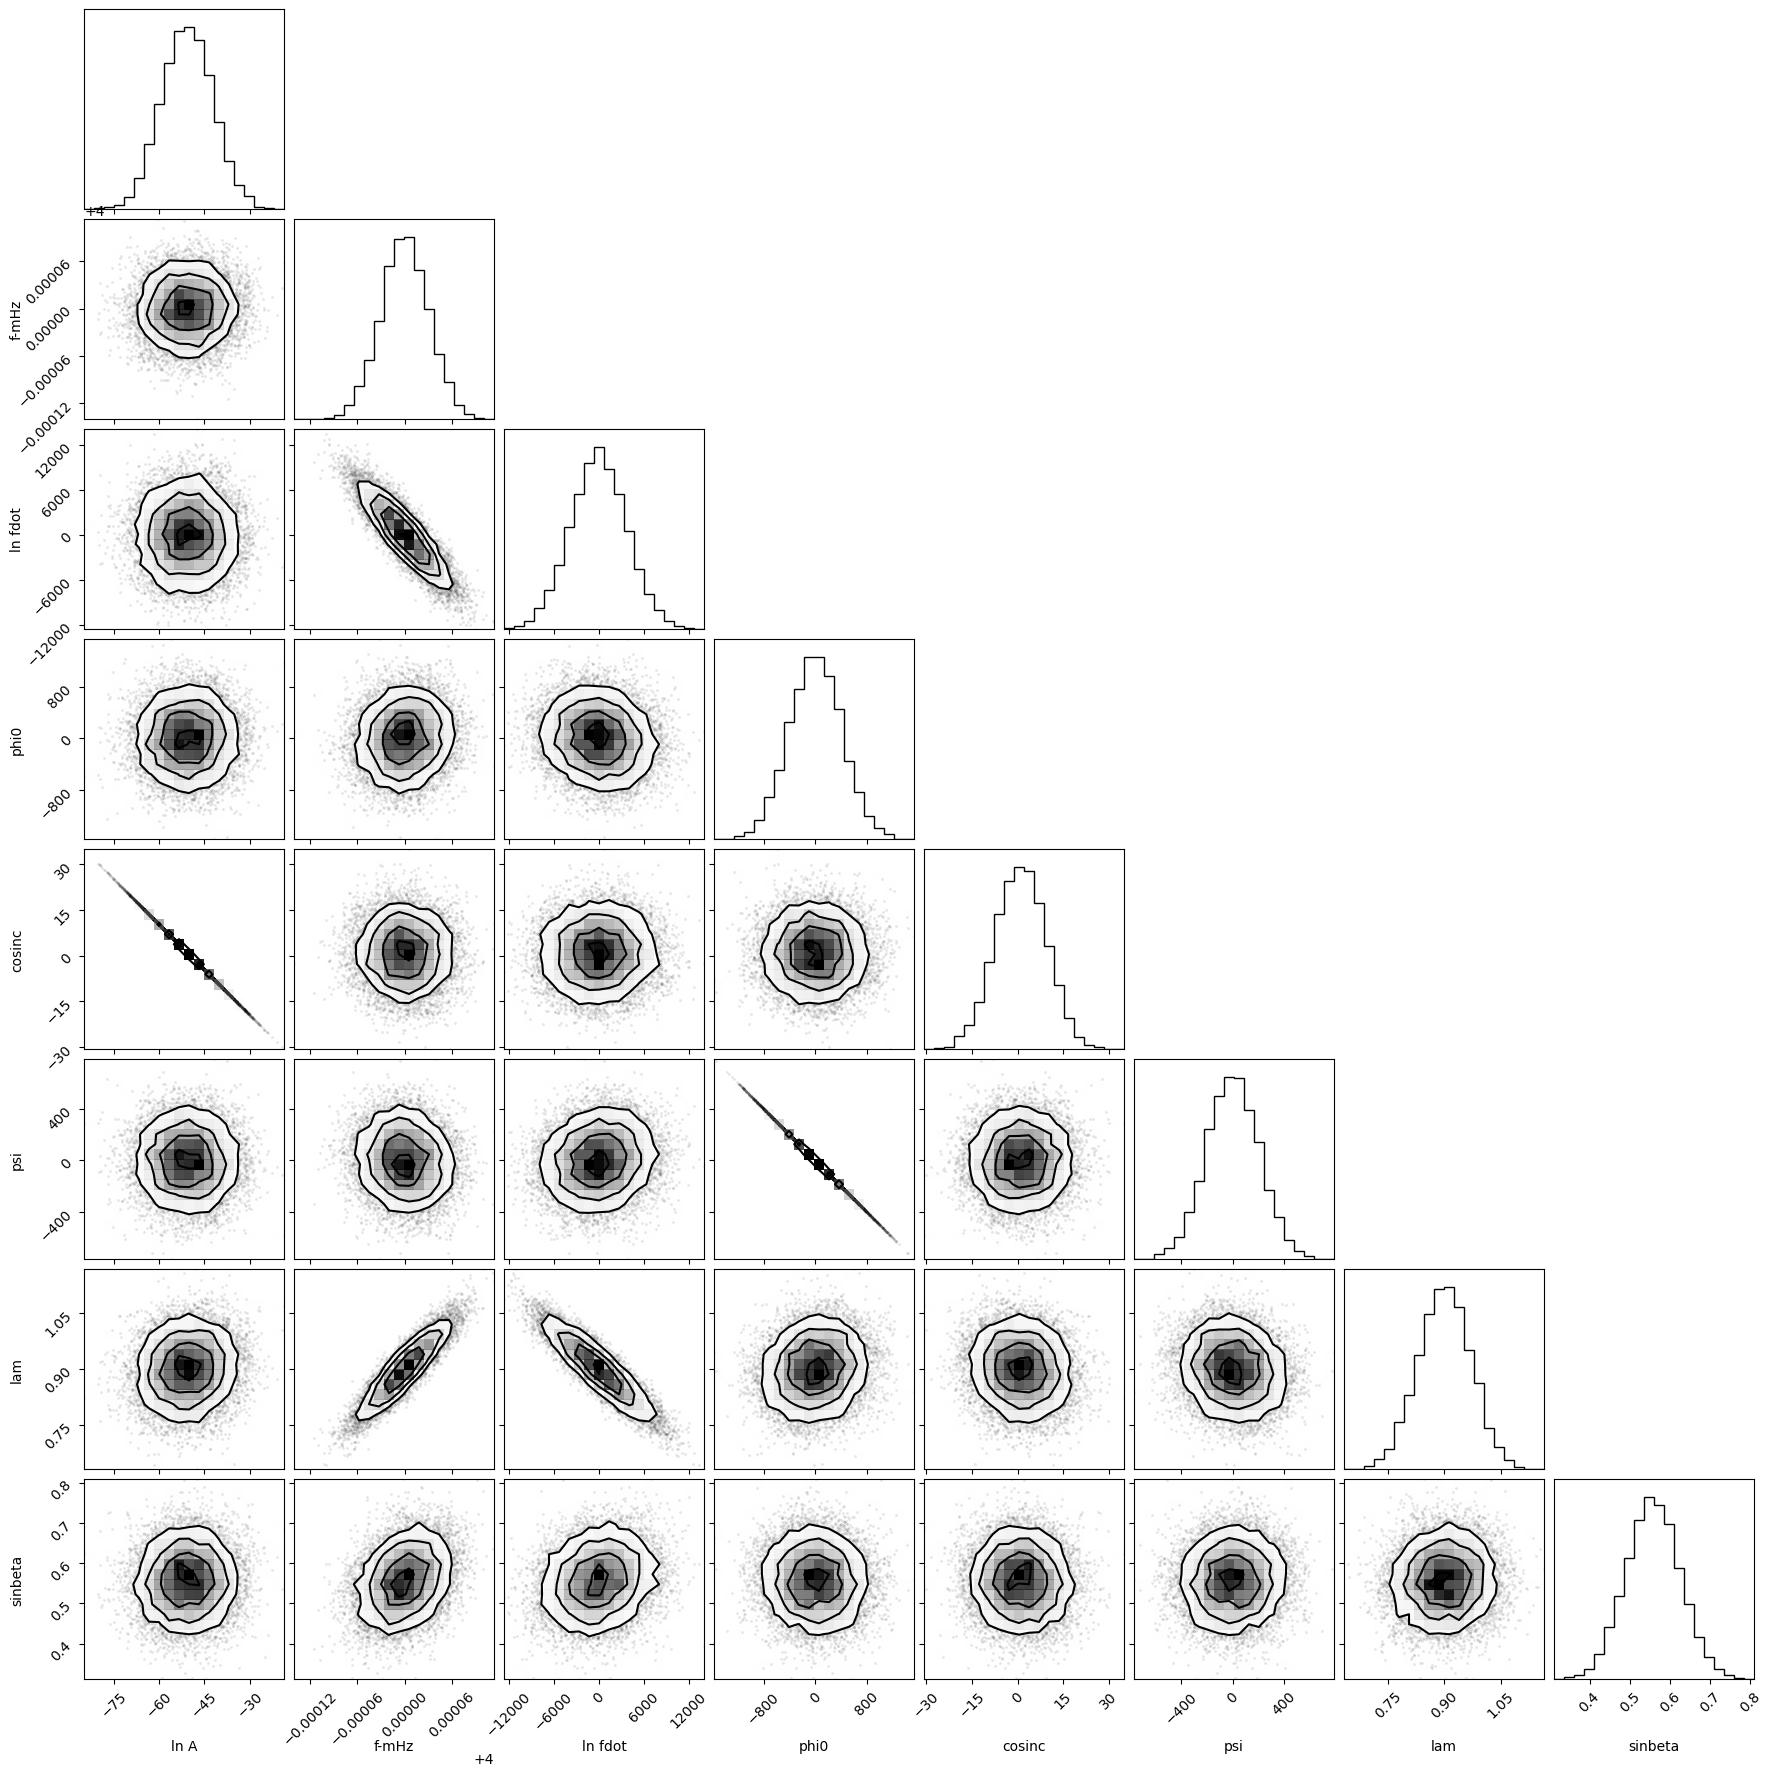

In [14]:
labels=["ln A", "f-mHz", "ln fdot", "phi0", "cosinc", "psi", "lam", "sinbeta"]
plot_covariance_corner(scaled_inj_params, cov, labels=labels, nsamp=10000)

#### VGBs Specifically

In [15]:
vgbs = pd.read_csv("vgbs.txt")

lisa b'HPLib' 8.126391060366705
lisa b'ZTFJ2320' 0.01836013299465549
lisa b'SDSSJ0923' 0.20284347112882584
lisa b'AMCVn' 14.799453128072539
lisa b'CX1751' 0.7309513766094841
lisa b'ZTFJ2029' 0.6274446467730479
lisa b'SDSSJ0935' 7.865112186872143
lisa b'ZTFJ1539' 28.54251728025299
lisa b'SDSSJ2322' 3.648797526114858
lisa b'4U1820-30' 1.873127538384317
lisa b'HMCnc' 75.27142784882075
lisa b'CRBoo' 2.7687102540460775
lisa b'PTFJ0533' 0.9983470397545212
lisa b'HD265435' 0.06905757674551208
lisa b'CDm30' 0.16438508217450823
lisa b'ZTFJ0640' 0.047898922939256884
lisa b'ZTFJ1749' 0.4075163758763989
lisa b'SMSSJ0338' 0.6767834850994286
lisa b'SDSSJ1630' 0.3426282634464875
lisa b'ZTFJ2055' 0.03049112465478392
lisa b'ZTFJ1901' 0.1563438149712383
lisa b'ZTFJ1946' 0.09091404217486056
lisa b'ESCet' 18.89788605928842
lisa b'SDSSJ1337' 0.13188449289501603
lisa b'ZTFJ2130' 0.16830059639947037
lisa b'V407Vul' 23.42031538677392
lisa b'ZTFJ2243' 17.178446114984375
lisa b'SDSSJ0634' 2.7690194331526428
lis

/Users/mlkatz1/miniconda3/envs/2050_env/lib/python3.12/site-packages/lisatools/diagnostic.py:376: RuntimeWarning: invalid value encountered in sqrt
  opt_snr = np.sqrt(inner_product(sig1, sig1, *args, **kwargs).real)


muares b'CRBoo' 53006.86559526818
muares b'PTFJ0533' 2723.270341275061
muares b'HD265435' 29595.718067644964
muares b'CDm30' 1021.9778706093259
muares b'ZTFJ0640' 726.6716350778842
muares b'ZTFJ1749' 2898.5790931505985
muares b'SMSSJ0338' 7712.092350449798
muares b'SDSSJ1630' 3572.4977573825777
muares b'ZTFJ2055' 2.0842860849791296
muares b'ZTFJ1901' 1947.4689666401491
muares b'ZTFJ1946' 3223.275874545856
muares b'ESCet' 11066.499644867105
muares b'SDSSJ1337' 120865.69487692972
muares b'ZTFJ2130' 1586.6014197305421
muares b'V407Vul' nan
muares b'ZTFJ2243' 6853.339615120016
muares b'SDSSJ0634' 13762.285274906128
muares b'ZTFJ0722' 96468.10823162475
muares b'PTF1919' 597.5963465039176
muares b'V803Cen' 19254.650247215803
muares b'SDSSJ1351' 36751.926274771526
muares b'SDSSJ1235' 540.0663138562646
muares b'ZTFJ0538' 28.081056917009743
muares b'SDSSJ0651' 7071.89002705456
muares b'SDSSJ1908' 3103.52988288248
do_con b'HPLib' 0.045887619170527104
do_con b'ZTFJ2320' 7.970048673401598e-05
do_c

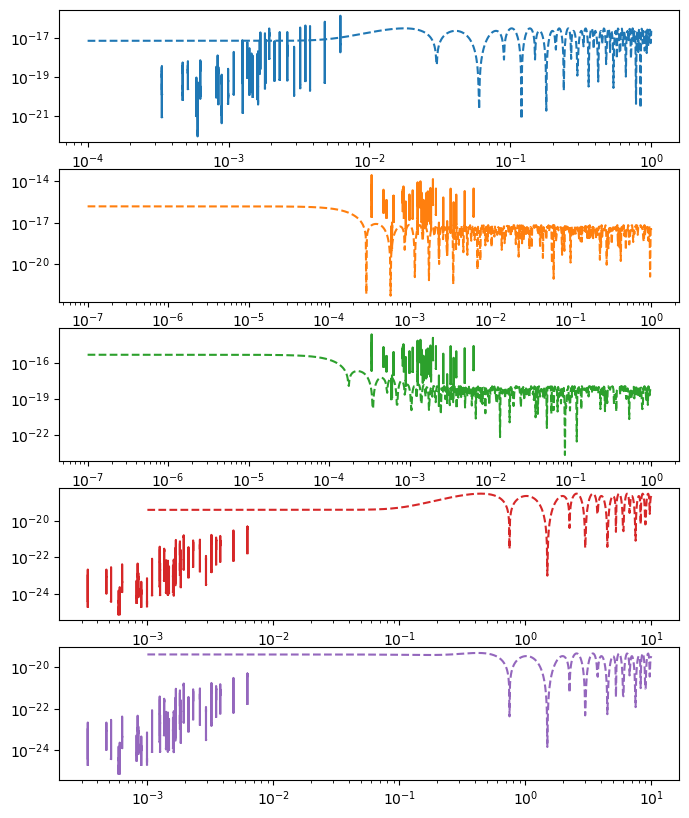

In [16]:
fig, ax = plt.subplots(len(list(missions.keys())), 1, figsize=(8, 2 * len(list(missions.keys()))))
for i, (name, mission) in enumerate(missions.items()):
    fn = mission["model"].fn
    Sn = get_sensitivity(fn, model=mission["model"], sens_fn=A1TDISens, **mission["psd_kwargs"])
    df = get_df(mission["Tobs"], mission["dt"])
    ax[i].loglog(fn, (Sn / (4 * df)) ** (1/2), c=f"C{i}", ls="--")
    for j in range(len(vgbs)):
        vgb = vgbs.iloc[j]
        params_in = np.array([
            vgb["Amplitude"],
            vgb["Frequency"],
            vgb["FrequencyDerivative"],
            0.0,
            vgb["InitialPhase"],
            vgb["Inclination"],
            vgb["Polarization"],
            vgb["EclipticLongitude"],
            vgb["EclipticLatitude"]
        ])
        print(name, vgb["Name"], mission["gb"].get_snr(*params_in, tdi2=True))
        ax[i].loglog(mission["gb"].f_arr, np.abs(mission["gb"].last_output[0]), c=f"C{i}")

### EMRIs

In [ ]:
M = 1e6
mu = 1e1
a = 0.2
p0 = 12.0
e0 = 0.2
x0 = 0.1
dist = 3.0
phiS = 0.4423
qS = 0.523023
qK = 0.8923123
phiK = 0.1221209312
Phi_phi0 = 0.1231232
Phi_theta0 = 4.234903824
Phi_r0 = 3.230923

emri_injection_params = np.array(
    [M, mu, a, p0, e0, x0, dist, qS, phiS, qK, phiK, Phi_phi0, Phi_theta0, Phi_r0]
)

fig, ax = plt.subplots(len(list(missions.keys())), 1, figsize=(8, 6))

for i, (name, mission) in enumerate(missions.items()):
    # cannot handle decihertz without adjustments. 
    if name in ["do_con", "do_opt"]: 
        continue
    fn = mission["model"].fn
    print(name, mission["emri"].get_snr(*emri_injection_params))
    Sn = get_sensitivity(fn, model=mission["model"], sens_fn=A1TDISens, **mission["psd_kwargs"])
    emri_freqs = np.fft.rfftfreq(mission["emri"].last_output[0].shape[0], mission["emri"].aet_template_gen.dt)
    ax[i].loglog(emri_freqs, emri_freqs * np.abs(np.fft.rfft(mission["emri"].last_output[0])) * mission["emri"].aet_template_gen.dt, c=f"C{i}")
    ax[i].loglog(fn, np.sqrt(fn) * (Sn / (4 * df)) ** (1/2), c=f"C{i}", ls="--")
